In [1]:
# default_exp utils

In [59]:
# export
from multiinstance.data.syntheticData import buildDataset
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np

import community as community_louvain
import networkx as nx
import igraph as ig
import leidenalg
from itertools import chain

from dist_curve.curve_constructor import makeCurve, plotCurve
from dist_curve.model import getTrainedEstimator
from tqdm.notebook import tqdm
import seaborn as sns

In [15]:
import scipy.stats as ss

In [3]:
# export
estimator = getTrainedEstimator()

In [58]:
# export
def getBootstrapSample(p,u):
    ps = np.random.choice(np.arange(p.shape[0]), size=len(p), replace=True)
    ps = p[ps]
    us = np.random.choice(np.arange(u.shape[0]), size=len(u), replace=True)
    us = u[us]
    return ps, us

def getEsts(p,u, numbootstraps):
    curves = np.zeros((numbootstraps, 100))
    alphaHats = np.zeros(numbootstraps)
    for i in tqdm(range(numbootstraps),
                  total=numbootstraps,
                  desc="running makeCurve bootstrap repetition",leave=False):
        ps, us = getBootstrapSample(p,u)
        curve = makeCurve(ps,us).reshape((1,-1))
        curves[i] = curve
        curve /= curve.sum()
        est = estimator(curve)
        alphaHats[i] = est
    return alphaHats, curves

def getBagAlphaHats(ds, numbootstraps=100):
    alphaHats =np.zeros((ds.N, numbootstraps))
    curves =np.zeros((ds.N, numbootstraps, 100))
    for bagIdx in tqdm(range(ds.N), total=ds.N, desc="getting bag estimates",leave=False):
        _,u = ds.getBag(bagIdx)
        ps, _ = list(zip(*[ds.getBag(int(i)) for i in range(ds.N)]))
        p = np.concatenate(ps)
        alphaHats[bagIdx], curves[bagIdx] = getEsts(p,u, numbootstraps)
    return alphaHats, curves


def getCliqueAlphaHats(ds, cliques, numbootstraps=10):
    Nc = len(cliques)
    alphaHats = np.zeros((Nc, numbootstraps))
    curves = np.zeros((Nc, numbootstraps, 100))
    for cnum, clique in tqdm(enumerate(cliques), total=Nc, desc="getting clique alpha ests", leave=False):
        _, us = list(zip(*[ds.getBag(int(i)) for i in clique]))
        ps, _ = list(zip(*[ds.getBag(int(i)) for i in range(ds.N)]))
        p = np.concatenate(ps)
        u = np.concatenate(us)
        alphaHats[cnum], curves[cnum] = getEsts(p,u, numbootstraps)
    return alphaHats, curves

def getAlphaPrime(cliques, cliqueEsts):
    bagNums = set(chain.from_iterable(cliques))
    alphaPrime = np.zeros(len(bagNums))
    for bn in bagNums:
        inClique = [bn in c for c in cliques]
        alphaPrime[bn] = cliqueEsts[inClique].mean()
    return alphaPrime

In [5]:
# export
def getKSMatrixPMatrix(samples):
    "Get Kolmogrov-Smirnov adjacency matrix from lists of lists of samples for each bag"
    N = samples.shape[0]
    pmat = np.zeros((N,N))
    for bag0Idx in tqdm(range(N),total=N, desc="making kolmogorov-smirnov adj matrix", leave=False):
        for bag1Idx in range(bag0Idx+ 1,N):
            stat,p = ks_2samp(samples[bag0Idx], samples[bag1Idx])
            pmat[bag0Idx, bag1Idx] = p
            pmat[bag1Idx, bag0Idx] = p
    return pmat

def getAllCliques(mat, cutoffval=0.05):
    """
    given matrix of pairwise test p-values, 
    make adjacency matrix using specified
    confidence level then find all cliques for each bag
    """
    adj = mat > cutoffval
    g = nx.from_numpy_array(adj)
    return list(nx.algorithms.clique.find_cliques(g))

def clusterByLeidenAlg(similarityMatrix, resolution_parameter = 1.5):
    """
    https://medium.com/@ciortanmadalina
    This method partitions input data by applying the Leiden algorithm
    on a given distance matrix.
    """
    # convert distance matrix to similariy matrix
    distanceMatrix = similarityMatrix
    edges = np.unravel_index(np.arange(distanceMatrix.shape[0]*distanceMatrix.shape[1]), distanceMatrix.shape)
    edges = list(zip(*edges))
    weights = distanceMatrix.ravel()
    
    g = ig.Graph(directed=False)
    g.add_vertices(distanceMatrix.shape[0])  # each observation is a node
    g.add_edges(edges)
    
    g.es['weight'] = weights
    weights = np.array(g.es["weight"]).astype(np.float64)
    partition_type = leidenalg.RBConfigurationVertexPartition
    partition_kwargs = {}
    partition_kwargs["weights"] = weights
    partition_kwargs["resolution_parameter"] = resolution_parameter
    part = leidenalg.find_partition(g, partition_type, **partition_kwargs)
    groupAssignment = np.array(part.membership)
    groups = [np.where(groupAssignment==g)[0] for g in np.unique(groupAssignment)]
    return groups

In [57]:
# export
def getOptimalAdjacency(trueAlphas):
    N = trueAlphas.shape[0]
    adj = np.zeros((N,N))
    for i,a0 in enumerate(trueAlphas):
        for j,a1 in enumerate(trueAlphas[i+1:],start=i+1):
            adj[i,j] = np.abs(a0 - a1)
            adj[j,i] = np.abs(a0 - a1)
    return adj

In [49]:
primeAEs = []
baselineAEs = []
localAEs = []

In [50]:
Nreps = 5
for rep in tqdm(range(Nreps),desc="dataset repetition",total=Nreps):
    ds0 = buildDataset(100, alphaDistr=lambda: np.random.beta(2,10))

    ds0.alphaHats, ds0.curves = getBagAlphaHats(ds0,10)

#     ds0.pmat = getKSMatrixPMatrix(ds0.alphaHats)
    # ds0.clusters = clusterByLeidenAlg(ds0.pmat > .05)
#     ds0.clusters = getAllCliques(ds0.pmat, cutoffval=1e-5)
    ds0.adj = getOptimalAdjacency(ds0.trueAlphas)
#     ds0.clusters = getAllCliques(ds0.adj)
    ds0.clusters = clusterByLeidenAlg(ds0.adj)
    ds0.clusterAlphaHat, ds0.clusterCurves = getCliqueAlphaHats(ds0,ds0.clusters, numbootstraps=10)

    ds0.alphaPrime = getAlphaPrime(ds0.clusters, ds0.clusterAlphaHat)

    globalAlphaHat,_ = getCliqueAlphaHats(ds0, [np.arange(ds0.N)], numbootstraps=10)

    primeAEs.append(np.abs(ds0.alphaPrime - ds0.trueAlphas))
    localAEs.append(np.abs(ds0.alphaHats - ds0.trueAlphas))
    baselineAEs.append(np.abs(ds0.trueAlphas - globalAlphaHat.mean()))

In [51]:
np.mean(primeAEs)

0.12845213438295564

In [52]:
np.mean(baselineAEs)

0.2680340758799414

In [53]:
np.mean(localAEs)

0.15299062432277682

In [54]:
order = ds0.trueAlphas.flatten().argsort().flatten()

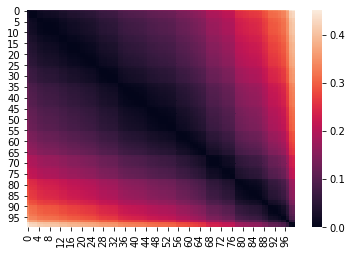

In [55]:
sns.heatmap(ds0.adj[order][:,order])


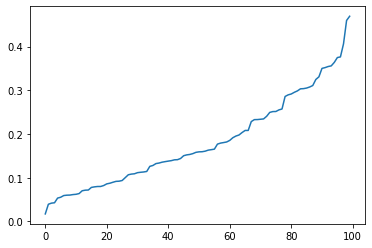

In [56]:
plt.plot(sorted(ds0.trueAlphas))

In [ ]:
def minmax(v):
    mi = v.min()
    ma = v.max()
    return (v - mi) / (ma - mi)

def makeFig(curves, trueAlphas, localAlphaHat, globalAlpha, alphaPrimes,N=40):
    ncols = 4
#     N = curves.shape[0]
    nrows = int(np.ceil(N/ncols))
    fig,ax = plt.subplots(nrows,ncols,figsize=(20,20))
    for bagNum in range(N):
        axrow, axcol = int(bagNum / ncols), int(bagNum % ncols)
        # shade between bin and max for each point in curve
        curveQuants = np.quantile(minmax(curves[bagNum]),[0,1],axis=0)
        ax[axrow,axcol].fill_between(np.arange(0,1,.01),
                                     curveQuants[0],
                                     y2=curveQuants[1],
                                     color="blue",alpha=0.25)
        # Plot average curve line
        ax[axrow,axcol].plot(np.arange(0,1,.01),
                             minmax(curves[bagNum]).mean(0),
                             color="magenta")
        # plot true alpha in black
        ax[axrow,axcol].vlines(trueAlphas[bagNum],0,1,
                               color="black", alpha=.25)
        # shade in range of alphas in red
        ax[axrow,axcol].fill_betweenx([0,1],
                          np.min(localAlphaHat[bagNum]),
                          x2=np.max(localAlphaHat[bagNum]),
                                      label=r"$ \hat{ \alpha } $"+ " range",
                                      color="red",alpha=.25)
        # plot average local estimate in red
        ax[axrow,axcol].vlines(np.mean(localAlphaHat[bagNum]),0,1,color="red")
        # plot adjusted estimate in green
        ax[axrow,axcol].vlines(alphaPrimes[bagNum],0,1, label="alpha prime",color="green")
        # Global Alpha in Blue
        ax[axrow,axcol].vlines(globalAlpha, 0, 1, color="blue")
    plt.savefig("/ssdata/downloads/fig.pdf",format="pdf")
    return fig

In [ ]:
clusterFig = makeFig(ds0.clusterCurves,
                     [[ds0.trueAlphas[i] for i in c] for c in ds0.clusters],
                     ds0.clusterAlphaHat,
                     globalAlphaHat.mean(),
                     np.zeros(ds0.clusterCurves.shape[0]),
                     N=ds0.clusterCurves.shape[0])

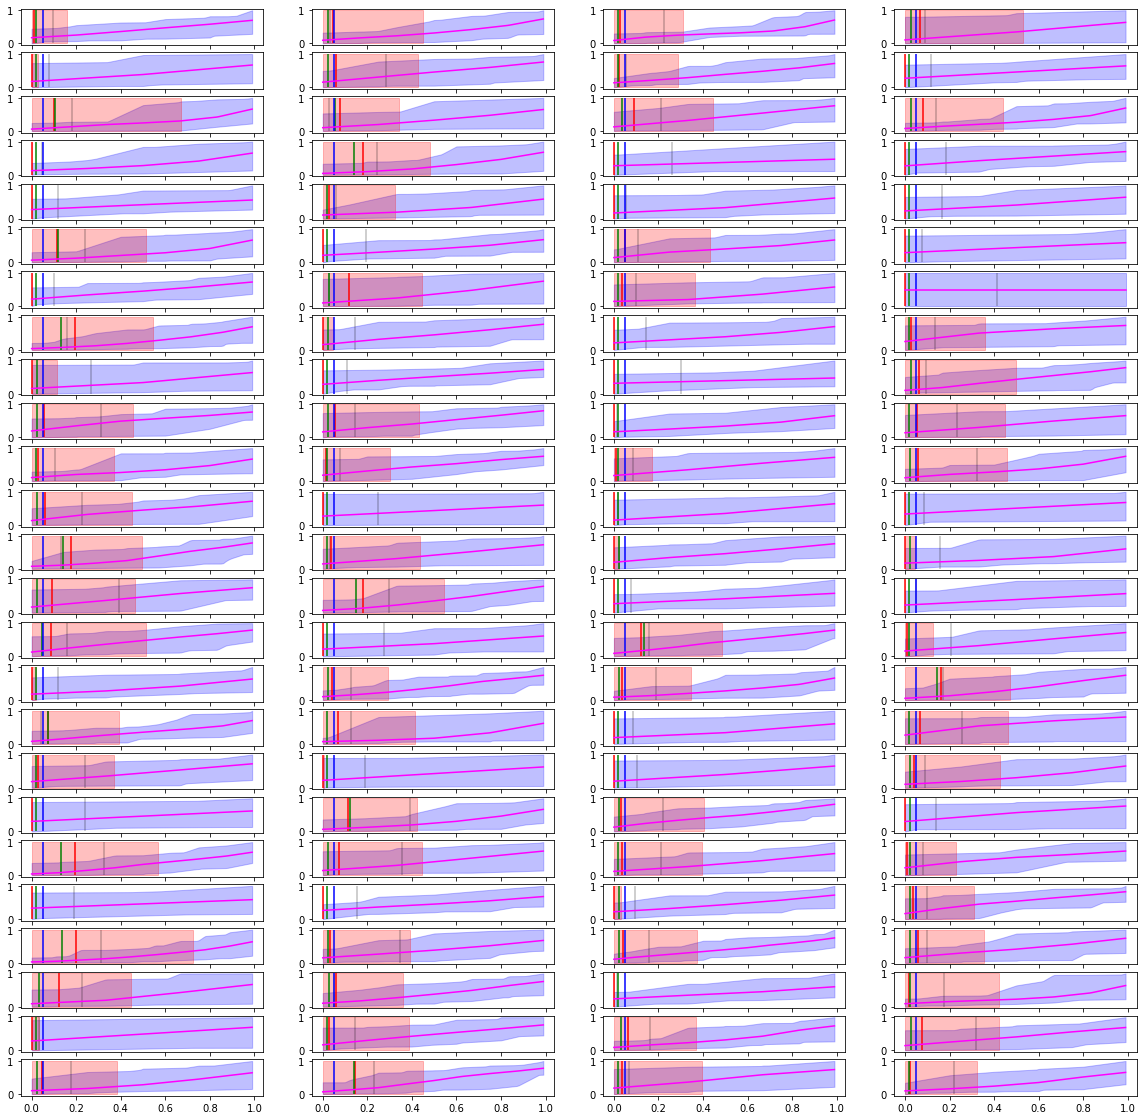

In [14]:
bagfig = makeFig(ds0.curves, ds0.trueAlphas, ds0.alphaHats, np.mean(globalAlphaHat), ds0.alphaPrime,N=ds0.N)